# Evaluation, Interpretability & Trust

This notebook complements **Phase 2 (modeling + cross-validation)** by adding evaluation and interpretability outputs for a **30‑day readmission risk** classifier.

## Why two evaluation views?

- **Cross-validation (Phase 2)** is used for **model selection** and is typically the most *realistic* estimate while you iterate (because each prediction is made on data not used to train that fold).
- **Holdout evaluation (this notebook)** is used to generate **stable, easy-to-read plots** (ROC/PR curves, calibration, confusion matrix) and to run **permutation importance** and simple **group diagnostics**.

Important detail: the saved artifact `artifacts/model.joblib` is trained on the **full dataset** (good for deployment).  
To avoid evaluation leakage, this notebook refits a **fresh clone** of that pipeline on the holdout *training split* before computing holdout metrics and explainability.

## Visible deliverables (charts)

- Confusion matrix at the chosen decision threshold
- ROC curve and Precision–Recall curve
- Calibration curve + Brier score
- Permutation importance (global feature drivers)
- Lightweight group diagnostics across gender / race

## Prerequisites

Run Phase 1 + Phase 2 first so these exist:
- `data/processed/readmission.duckdb`
- `artifacts/model.joblib`
- `artifacts/threshold.json`
- (optional) `artifacts/cv_results.csv`, `artifacts/threshold_analysis.csv`


In [1]:
from __future__ import annotations

from pathlib import Path
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    brier_score_loss,
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve

def find_project_root(start: Path | None = None) -> Path:
    """Walk upwards to find the project root (folder containing 'data' and 'src')."""
    start = start or Path.cwd()
    cur = start.resolve()
    for _ in range(10):
        if (cur / 'data').exists() and (cur / 'src').exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError('Could not locate project root. Run the notebook from inside the project folder.')

ROOT = find_project_root()
SRC_DIR = ROOT / 'src'
sys.path.insert(0, str(SRC_DIR))

DB_PATH = ROOT / 'data' / 'processed' / 'readmission.duckdb'
ART_DIR = ROOT / 'artifacts'

print('Project root:', ROOT)
print('DB path:', DB_PATH)
print('Artifacts:', ART_DIR)

Project root: C:\Users\amirm\Programming\Data Science Portfolio\projects\health-readmission-risk
DB path: C:\Users\amirm\Programming\Data Science Portfolio\projects\health-readmission-risk\data\processed\readmission.duckdb
Artifacts: C:\Users\amirm\Programming\Data Science Portfolio\projects\health-readmission-risk\artifacts


## 1) Load data and artifacts

We load the cleaned dataset from DuckDB and the trained pipeline artifacts created in Phase 2.

In [2]:
import train  # src/train.py

if not DB_PATH.exists():
    raise FileNotFoundError(f'DuckDB not found: {DB_PATH}. Run Phase 1 ingestion first.')
if not (ART_DIR / 'model.joblib').exists():
    raise FileNotFoundError('model.joblib not found. Run Phase 2 first.')
if not (ART_DIR / 'threshold.json').exists():
    raise FileNotFoundError('threshold.json not found. Run Phase 2 first.')

df = train.load_encounters(DB_PATH, table='encounters')
X, y = train.prepare_xy(df, target_col='readmission_30d')

model = joblib.load(ART_DIR / 'model.joblib')
threshold_cfg = json.loads((ART_DIR / 'threshold.json').read_text(encoding='utf-8'))
threshold = float(threshold_cfg['threshold'])
model_name = str(threshold_cfg.get('model_name', 'unknown'))

print('Loaded model:', model_name)
print('Chosen threshold:', threshold)
print('Dataset shape:', X.shape)
print('Positive rate:', float(y.mean()))


Loaded model: rf
Chosen threshold: 0.20999999999999996
Dataset shape: (101766, 47)
Positive rate: 0.11159915885462728


### Phase 2 artifacts (optional)

If these files exist, we display them to connect Phase 2 decisions to Phase 3 plots.

,model_name,roc_auc,pr_auc,precision,recall,f1,threshold
0,rf,0.669122,0.216191,0.156897,0.722374,0.257801,0.21
1,logreg,0.648945,0.199378,0.149441,0.703531,0.246517,0.45


,threshold,precision,recall,f1
0,0.05,0.111842,1.000000,0.201183
1,0.06,0.112000,0.999648,0.201432
2,0.07,0.112297,0.998327,0.201886
3,0.08,0.112827,0.996302,0.202700
4,0.09,0.113636,0.993484,0.203944


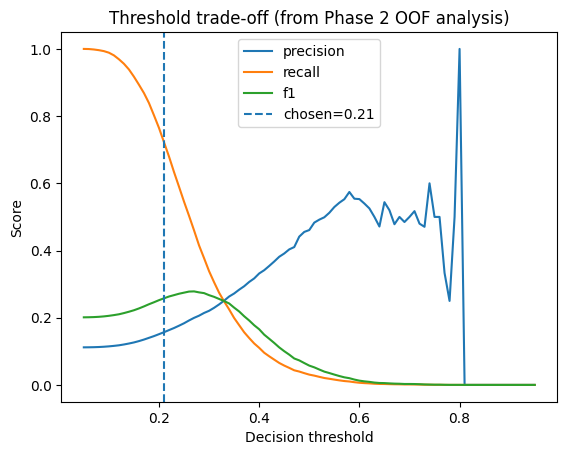

In [3]:
# Optional: show Phase 2 CV leaderboard and threshold trade-off curves
cv_path = ART_DIR / "cv_results.csv"
th_path = ART_DIR / "threshold_analysis.csv"

if cv_path.exists():
    cv_df = pd.read_csv(cv_path)
    # Show best models first (PR-AUC primary under imbalance)
    display(cv_df.sort_values(by=["pr_auc", "roc_auc"], ascending=False).head(10))
else:
    print("cv_results.csv not found (optional).")

if th_path.exists():
    th_df = pd.read_csv(th_path)
    display(th_df.head())

    # Plot precision/recall/F1 vs threshold (computed on OOF predictions in Phase 2)
    plt.figure()
    plt.plot(th_df["threshold"], th_df["precision"], label="precision")
    plt.plot(th_df["threshold"], th_df["recall"], label="recall")
    plt.plot(th_df["threshold"], th_df["f1"], label="f1")
    plt.axvline(threshold, linestyle="--", label=f"chosen={threshold:.2f}")
    plt.xlabel("Decision threshold")
    plt.ylabel("Score")
    plt.title("Threshold trade-off (from Phase 2 OOF analysis)")
    plt.legend()
    plt.show()
else:
    print("threshold_analysis.csv not found (optional).")


## 2) Phase 2 recap (cross-validation) + holdout protocol

### Phase 2 recap
If available, we will load:
- `cv_results.csv`: the CV leaderboard across candidate models
- `threshold_analysis.csv`: precision/recall/F1 across thresholds (computed on out-of-fold probabilities)

These are the most realistic estimates for model comparison and threshold selection.

### Holdout protocol used in this notebook
We create a single **stratified** 80/20 split for plots and interpretability.  
Because `model.joblib` was trained on the full dataset, we **refit a clone** of the pipeline on `X_train` only, then evaluate on the unseen `X_test`.


In [4]:
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Stratified holdout split (used for plots and interpretability)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# IMPORTANT:
# - artifacts/model.joblib is trained on the full dataset (deployment-ready).
# - For a true holdout evaluation, refit a fresh clone on X_train only.
model_holdout = clone(model)
model_holdout.fit(X_train, y_train)

proba_test = model_holdout.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= threshold).astype(int)

# Summary metrics
base_rate = float(y_test.mean())
pred_pos_rate = float(pred_test.mean())

metrics = {
    "n_test": int(len(y_test)),
    "base_rate": base_rate,
    "predicted_positive_rate": pred_pos_rate,
    "roc_auc": float(roc_auc_score(y_test, proba_test)),
    "pr_auc": float(average_precision_score(y_test, proba_test)),
    "brier": float(brier_score_loss(y_test, proba_test)),
    "accuracy": float(accuracy_score(y_test, pred_test)),
    "precision@thr": float(precision_score(y_test, pred_test, zero_division=0)),
    "recall@thr": float(recall_score(y_test, pred_test, zero_division=0)),
    "f1@thr": float(f1_score(y_test, pred_test, zero_division=0)),
    "threshold": float(threshold),
}

pd.DataFrame([metrics])


,n_test,base_rate,predicted_positive_rate,roc_auc,pr_auc,brier,accuracy,precision@thr,recall@thr,f1@thr,threshold
0,20354,0.111575,0.517343,0.674728,0.224207,0.107678,0.534981,0.158405,0.734478,0.260605,0.21


## 3) Confusion matrix (decision-level behavior)

This shows the trade-off at the chosen threshold (false positives vs false negatives).

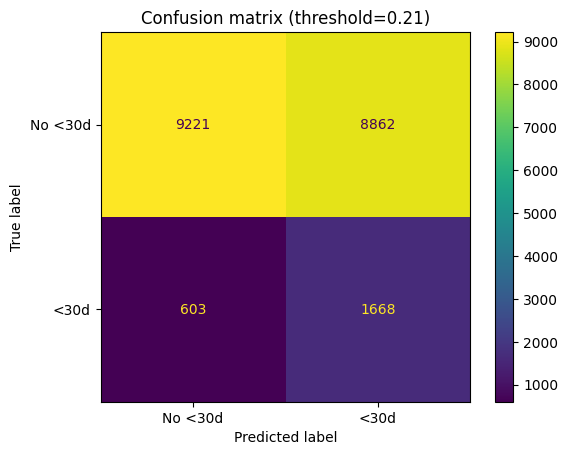

In [5]:
cm = confusion_matrix(y_test, pred_test, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No <30d', '<30d'])
disp.plot(values_format='d')
plt.title(f'Confusion matrix (threshold={threshold:.2f})')
plt.show()


## 4) Discrimination curves (ranking quality)

ROC-AUC measures ranking quality overall; PR-AUC is more informative under class imbalance.

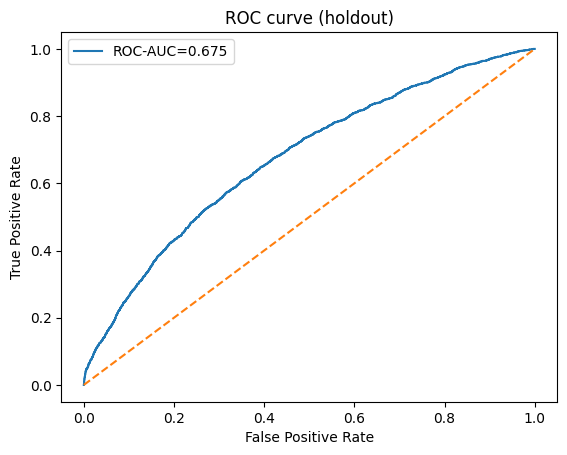

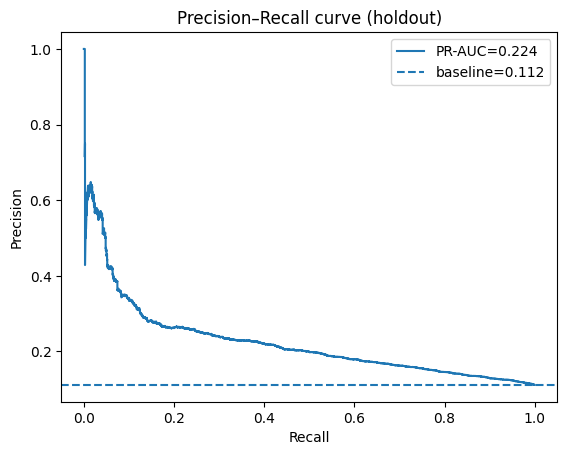

In [6]:
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC={metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (holdout)")
plt.legend()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure()
plt.plot(rec, prec, label=f"PR-AUC={metrics['pr_auc']:.3f}")
# Baseline PR level equals the positive prevalence
plt.axhline(metrics["base_rate"], linestyle="--", label=f"baseline={metrics['base_rate']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (holdout)")
plt.legend()
plt.show()


## 5) Calibration (probability quality)

Calibration checks whether predicted probabilities correspond to observed frequencies. Brier score is a proper scoring rule for probability forecasts.

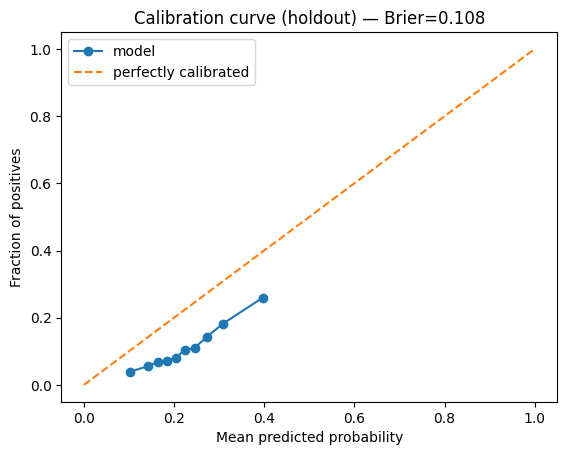

In [7]:
prob_true, prob_pred = calibration_curve(
    y_test, proba_test, n_bins=10, strategy="quantile"
)

plt.figure()
plt.plot(prob_pred, prob_true, marker="o", label="model")
plt.plot([0, 1], [0, 1], linestyle="--", label="perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title(f"Calibration curve (holdout) — Brier={metrics['brier']:.3f}")
plt.legend()
plt.show()


## 6) Global interpretability via permutation importance

Permutation importance answers: *how much does performance drop if we randomly shuffle one feature?*

In [8]:
perm = permutation_importance(
    model_holdout,
    X_test,
    y_test,
    scoring='average_precision',
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std,
}).sort_values('importance_mean', ascending=False)

imp.head(15)


,feature,importance_mean,importance_std
15,number_inpatient,0.055595,0.002469
5,discharge_disposition_id,0.024863,0.001893
16,diag_1,0.007875,0.001892
14,number_emergency,0.006797,0.000902
9,medical_specialty,0.005447,0.001770
2,age,0.004950,0.001299
7,time_in_hospital,0.004782,0.000934
8,payer_code,0.004196,0.000903
19,number_diagnoses,0.003131,0.001360
11,num_procedures,0.003060,0.001072


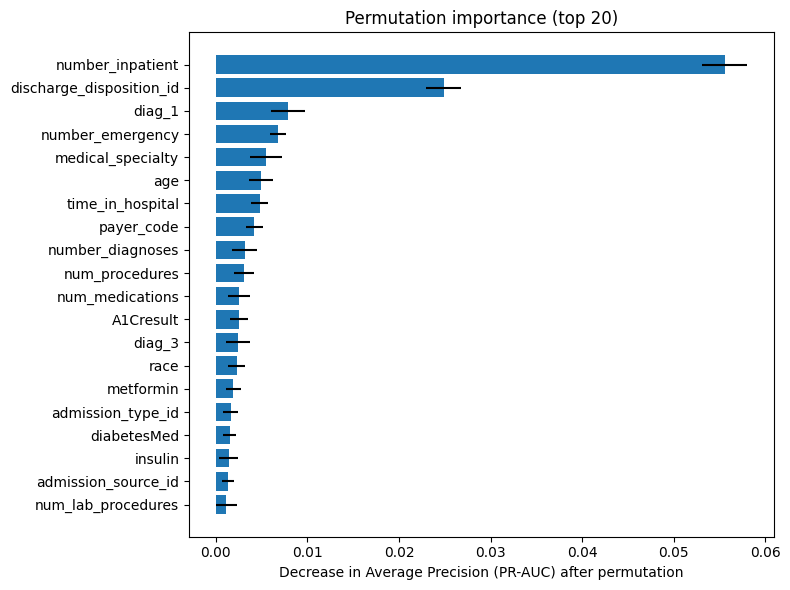

In [9]:
top_k = 20
imp_top = imp.head(top_k).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(imp_top['feature'], imp_top['importance_mean'], xerr=imp_top['importance_std'])
plt.xlabel('Decrease in Average Precision (PR-AUC) after permutation')
plt.title(f'Permutation importance (top {top_k})')
plt.tight_layout()
plt.show()


### How to read permutation importance

- Values represent the **drop in Average Precision (PR-AUC)** when a feature is randomly permuted.
- Higher values imply a feature is more important for the model's ranking performance **on the holdout set**.
- Important features here often act as proxies for **patient complexity and recent utilization** (e.g., prior inpatient visits, discharge disposition, time in hospital, diagnosis codes).

Caution: permutation importance can underestimate importance for strongly correlated features (importance may be "shared" across correlated columns).


## 7) Lightweight group diagnostics (race / gender)

This is **not** a full fairness audit. It is a quick diagnostic to spot large performance gaps across groups (using a minimum group size to reduce noise).


### What we report per group

For each group we report:
- `base_rate`: observed positive rate in that subgroup
- `predicted_positive_rate`: fraction predicted positive at the chosen threshold
- `precision`: among predicted positives, how many are true positives
- `recall`: among true positives, how many are detected

Large gaps may indicate dataset bias, model bias, or different prevalence and should be investigated before deployment.


In [10]:
df_eval = df.loc[X_test.index, ['race', 'gender', 'age']].copy()
df_eval['y_true'] = y_test.to_numpy()
df_eval['y_pred'] = pred_test
df_eval['y_proba'] = proba_test

def group_metrics(frame: pd.DataFrame, group_col: str, min_n: int = 500) -> pd.DataFrame:
    rows = []
    for g, sub in frame.groupby(group_col):
        n = len(sub)
        if n < min_n:
            continue
        y_true = sub['y_true'].to_numpy()
        y_pred = sub['y_pred'].to_numpy()
        tp = int(((y_true == 1) & (y_pred == 1)).sum())
        fp = int(((y_true == 0) & (y_pred == 1)).sum())
        fn = int(((y_true == 1) & (y_pred == 0)).sum())
        base_rate = float(y_true.mean())
        pred_rate = float(y_pred.mean())
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall = tp / (tp + fn) if (tp + fn) else 0.0
        rows.append({
            group_col: g,
            'n': n,
            'base_rate': base_rate,
            'predicted_positive_rate': pred_rate,
            'precision': float(precision),
            'recall': float(recall),
        })
    return pd.DataFrame(rows).sort_values('recall', ascending=False)

gm_gender = group_metrics(df_eval, 'gender', min_n=500)
gm_race = group_metrics(df_eval, 'race', min_n=500)

gm_gender


,gender,n,base_rate,predicted_positive_rate,precision,recall
0,Female,10924,0.114885,0.523343,0.164072,0.747410
1,Male,9430,0.107741,0.510392,0.151673,0.718504


In [11]:
gm_race

,race,n,base_rate,predicted_positive_rate,precision,recall
1,Caucasian,15223,0.112790,0.529528,0.157549,0.739662
0,AfricanAmerican,3866,0.111743,0.507760,0.160978,0.731481


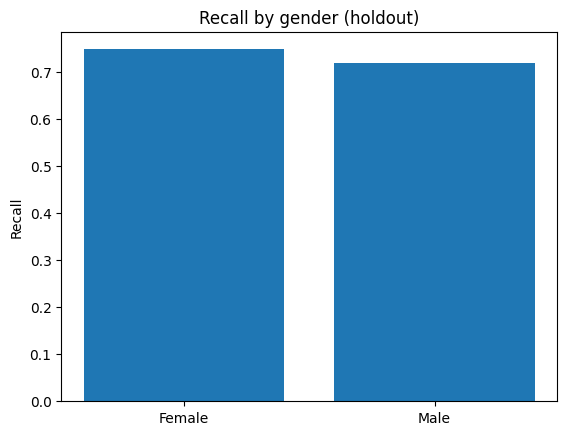

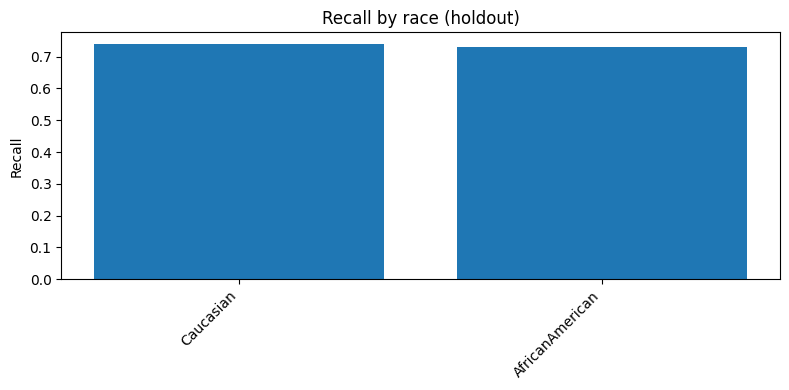

In [21]:
if len(gm_gender) > 0:
    plt.figure()
    plt.bar(gm_gender['gender'].astype(str), gm_gender['recall'])
    plt.ylabel('Recall')
    plt.title('Recall by gender (holdout)')
    plt.show()

if len(gm_race) > 0:
    plt.figure(figsize=(8, 4))
    plt.bar(gm_race['race'].astype(str), gm_race['recall'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Recall')
    plt.title('Recall by race (holdout)')
    plt.tight_layout()
    plt.show()


## 8) Limitations and next steps

- **Class imbalance**: positives are relatively rare; PR-AUC is emphasized alongside ROC-AUC.
- **Threshold policy**: the "best" threshold depends on business/clinical costs (missed readmissions vs alert fatigue).
- **Calibration**: if probabilities are used operationally (risk scores), consider probability calibration (Platt scaling / isotonic).
- **Leakage risk**: verify each feature is available at prediction time in a real workflow.
- **Representativeness**: this dataset is US hospitals (1999–2008); performance may shift in other settings.
